In [2]:

alpha,beta=0,0
batch_size = 1
batch_size_val=1
init_lr = 0.003
log_epoch=150
epoch_magnifiy,epoch_trouble=160,190
log_hot=150

epochs=400; train_size=6  
grad_accu_times = 2
if train_size==None: opt_step_size=(270/batch_size)*30 
else:opt_step_size=35*(train_size/batch_size)   

gpu_number = "0"            
noisy_sigma = 0.2            
noisy_smooth=2   
noisy_mean=0      

batch_norm=False 

leaky_relu=True;relu=False;elu=False 


weight_decay=1e-4
opt_gamma=0.55           
dropout_toggel,dropblock_toggle=False, True   
dropblock_blocks=5
dropblock_mid=9

dropout_amount=0.3

save_initial='unet_cas_opt'
import os
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number
# torch.cuda.set_device(1)
# device = torch.device("cuda:1,2")


# ('input unet', (2, 4, 172, 172, 128))
# ('first down', (2, 4, 86, 86, 64))
# ('Block 1 shape:', (2, 62, 86, 86, 64))
# ('Block 2 shape:', (2, 124, 43, 43, 32))
# ('Block 3 shape:', (2, 248, 21, 21, 16))
# ('Block 4 shape:', (2, 524, 10, 10, 8))
# ('Block Mid shape:', (2, 524, 5, 5, 4))
# ('BlockU 1 shape:', (2, 248, 10, 10, 8))
# ('BlockU 2 shape:', (2, 124, 21, 21, 16))
# ('BlockU 3 shape:', (2, 62, 43, 43, 32))
# ('BlockU 4 shape:', (2, 8, 86, 86, 64))
# ('unet output', (2, 2, 172, 172, 128))


# from DropBlock3d import DropBlock2D, DropBlock3D,LinearScheduler
import gzip
from sh import gunzip
import numpy as np
import pandas as pd
import gzip
import nibabel as nib
import matplotlib.pyplot as plt
import io
import torch
import torch.utils#.data.Dataset
import glob
#from sklearn.preprocessing import OneHotEncoder 
import imgaug as ia
from imgaug import augmenters as iaa
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from scipy import ndimage as nd
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
import warnings
warnings.filterwarnings('ignore')
from random import shuffle
from scipy.ndimage import rotate
from numpy import percentile
from skimage.transform import resize



import time
from torch.optim.lr_scheduler import StepLR
import torch as torch
from skimage import exposure
from tensorboardX import SummaryWriter
writer = SummaryWriter()
import pickle

def load_obj(name ):
    with open('/home/Drive3/rahul/'+ 'dicts'+ '.pkl', 'rb') as f:
        return pickle.load(f)
my_dict=load_obj('s')

hgg_dir='/home/Drive3/rahul/MICCAI_BraTS_2018_Data_Training/HGG/'
lgg_dir='/home/Drive3/rahul/MICCAI_BraTS_2018_Data_Training/LGG/'
csv_dir='/home/Drive3/rahul/MICCAI_BraTS_2018_Data_Training/brats.csv'
val_dir='/home/Drive3/rahul/MICCAI_BraTS_2018_Data_Training/brats_val/'

def classify_label(msk): 
    v=np.zeros((msk.size()[-1],3))
    for i in range(msk.size()[-1]):
        if (msk[:,:,i]==1).any(): v[i,0]=1
        if (msk[:,:,i]==2).any(): v[i,1]=1
        if (msk[:,:,i]==3).any(): v[i,2]=1
    return(torch.tensor(v).transpose(0,1)) # instead of trans can v->(3,size)

def noisy(image): 

    row,col,ch= image.shape   
    gauss = np.random.normal(noisy_mean,noisy_sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    noisy = nd.gaussian_filter(noisy, sigma=(noisy_smooth, noisy_smooth, noisy_smooth), order=0)

    return noisy


def standardizer(img,mod):

    if mod==0:mean=233.581878; std=204.35788
    elif mod==1:mean=599.1488; std=547.67474
    elif mod==2:mean=506.3251647; std=533.85250
    else: mean=388.70568; std=378.741204

    img=img-mean
    img=img/std
   
    quartiles = percentile(img, [99.5])  # exact region
    quartiles2 = percentile(img, [0.05]) 

    img=np.clip(img,quartiles2[0],quartiles[0])

    return(img)

pad=torch.nn.ConstantPad2d(1,0)
def padder(img): 
    
    padded=pad(img.transpose(3,4).transpose(2,3))[:,:,:,:-1,:-1]
    return(padded.transpose(2,3).transpose(3,4))
      
def padderh(img): 
    
    padded=pad(img.transpose(3,4).transpose(2,3))[:,:,:,:-1,1:-1]
    return(padded.transpose(2,3).transpose(3,4))
      
def padderw(img): 
    
    padded=pad(img.transpose(3,4).transpose(2,3))[:,:,:,1:-1,:-1]
    return(padded.transpose(2,3).transpose(3,4))
      
   
def one_hot(a):
    g1=a[:,:,:]==0
    g2=a[:,:,:]==1
    g3=a[:,:,:]==2
    # g4=a[:,:,:]==3
    return torch.stack((g1,g2,g3),0)

seq = iaa.Sequential([  iaa.Fliplr(1),iaa.Flipud(1) ])
seq2 = iaa.Fliplr(1)
seq3 = iaa.Flipud(1)

def read_img(flair,t1,t1ce,t2,seg,eg_name):
            try:flair = np.load(flair)[15:143,40:212,30:202]
            except: # string error in val 'B' missing from start
                l=[flair,t1,t1ce,t2,seg]
                for i in range(len(l)):
                    s=l[i].split('/')
                    s[-1]='B'+s[-1]
                    l[i]='/'.join(s)
                flair,t1,t1ce,t2,seg=l
                flair=np.load(flair)[15:143,40:212,30:202]

            t1 = np.load(t1)[15:143,40:212,30:202]
            t1ce = np.load(t1ce)[15:143,40:212,30:202]
            t2 = np.load(t2)[15:143,40:212,30:202]
            
            seg = np.array(nib.load(seg).dataobj)[40:212,30:202,15:143] 
#             print(np.unique(seg), '1') 
            
            seg= np.flipud(rotate(seg, 90, reshape=False)).copy()
#             seg=np.swapaxes(np.swapaxes(seg,1,2),1,0)
            
#             print(np.unique(seg), '2') 
            
            
            seg[seg==2]=0 # remove whole tumor class
            seg[seg==4]=2 # put liq in its place
            
#             print(np.unique(seg), '3') 
            
            flair=standardizer(flair,mod=0) ; t1=standardizer(t1,mod=1); t1ce=standardizer(t1ce,mod=2); t2=standardizer(t2,mod=3)
#             print('flair1',np.shape(flair))
            flair=noisy(flair) ; t1=noisy(t1); t1ce=noisy(t1ce); t2=noisy(t2)

            concat_full=np.concatenate([flair,t1,t1ce,t2],axis=0)
            concat_full=torch.tensor(concat_full).transpose(0,1).transpose(1,2).unsqueeze(3)
            
#             print(eg_name)
            h_min,h_max,w_min,w_max,d_min,d_max=my_dict[eg_name][0], my_dict[eg_name][1],my_dict[eg_name][2] ,my_dict[eg_name][3], my_dict[eg_name][4],my_dict[eg_name][5]
            
            print('dims',h_min,h_max,w_min,w_max,d_min,d_max)
            
            midh=int((h_max-h_min)/2)  # the mid points of wanted region
            midw=int((w_max-w_min)/2) 

            h=h_max-h_min
            w=w_max-w_min
            
            list32=[64,96,32*4,32*5,32*6]
            for i in range(len(list32)):
                if list32[i]-h>0:
                    sel_h=list32[i+1] # can make this i+1 or condition of greater than n margin
                    break
                    
            for i in range(len(list32)):
                if list32[i]-w>0:
                    sel_w=list32[i+1]
                    break
            
            
#             listd=[64,32*3,32*4]        # can make this i+1 or condition of greater than n margin
#             for i in range(len(listd)):
#                 if listd[i]-w>0:
#                     sel_d=listd[i+1]
                
                    
                    
            sel=max(sel_h,sel_w)
            sel=int(sel/2)
#             print('sizes', sel_h,sel_w,sel)
#             print('indexing', midh-sel,midh+sel, midw-sel,midw+sel)
#             print('mids',midh,midw)
#             print(np.shape(seg),np.shape(concat_full),'concat')
            
#             concat_full=concat_full[ max(0,midh-sel) : min(172,midh+sel), max(0,midw-sel):min(172,midw+sel), :,:]

            # index into the required dimensions
            concat_full2=concat_full[ max(0,midh-sel_h/2) : min(172,midh+sel_h/2), max(0,midw-sel_w/2):min(172,midw+sel_w/2), :,:]
            seg2=seg[max(0,midh-sel_h/2) : min(172,midh+sel_h/2), max(0,midw-sel_w/2):min(172,midw+sel_w/2), :]
#             print(np.shape(concat_full2),'after')
            
            # want dimensions to be div by 4 therefore sub/add to either side until condition is met. In some cases we are at edge so one will not work. sub or add choice is to only include extra region and not cut any
            counter=0
            while np.shape(concat_full2)[0]%4 !=0:
                counter+=1
                concat_full2=concat_full[ max(0,midh-sel_h/2 - counter) : min(172,midh+sel_h/2), max(0,midw-sel_w/2):min(172,midw+ sel_w/2), :,:]
                seg2=seg[ max(0,midh-sel_h/2 - counter) : min(172,midh+sel_h/2), max(0,midw-sel_w/2):min(172,midw+sel_w/2), :]
                if counter==4:break
                    
#             print(np.shape(concat_full2),'s1')
            
            if np.shape(concat_full2)[0]%4 ==0: flag=1
            else:flag=2
                
            counter=0     
            while np.shape(concat_full2)[0]%4 !=0:
                counter+=1
                concat_full2=concat_full[ max(0,midh-sel_h/2 ) : min(172,midh+sel_h/2 + counter), max(0,midw-sel_w/2):min(172,midw+sel_w/2), :,:]
                seg2=seg[ max(0,midh-sel_h/2 ) : min(172,midh+sel_h/2 + counter), max(0,midw-sel_w/2):min(172,midw+sel_w/2), :]
                if counter==4:break
                    
#             print(np.shape(concat_full2),'s2') 

            concat_fullnew=concat_full2
            segnew=seg2
            counter=0    
            
            while np.shape(concat_full2)[1]%4 !=0:
                counter+=1
                concat_full2=concat_fullnew[  : , max(0,midw-sel_w/2 - counter):min(172,midw+sel_w/2), :,:]
                seg2=segnew[  : , max(0,midw-sel_w/2 - counter):min(172,midw+sel_w/2), :]
                if counter==4:break
                    
#             print(np.shape(concat_full2),'s3')        
            counter=0       
            while np.shape(concat_full2)[1]%4 !=0:
                counter+=1
                concat_full2=concat_fullnew[  : , max(0,midw-sel_w/2):min(172,midw+sel_w/2  + counter), :,:]
                seg2=segnew[  : , max(0,midw-sel_w/2):min(172,midw+sel_w/2  + counter), :]
                if counter==4:break
                
#             print(np.shape(seg2),np.shape(concat_full2),'s4')    
                
            concat_full=concat_full2
            seg=seg2
            rand=np.random.choice([0,1,2,3,4])
#             print('seg',np.shape(seg))

            rand=100
            if rand==0: 
                concat_full=seq.augment_images((np.array(concat_full)))
                seg_orig=torch.tensor( seq.augment_images((np.array(seg).astype(int)))      )
            elif rand==1:
                concat_full=seq2.augment_images((np.array(concat_full)))
                seg_orig=torch.tensor( seq2.augment_images((np.array(seg).astype(int)))      )
            elif rand==2:
                concat_full=seq3.augment_images((np.array(concat_full)))
                seg_orig=torch.tensor( seq3.augment_images((np.array(seg).astype(int)))      )
            else:seg_orig=torch.tensor(seg.astype(int))
            
#             print('seg_orig',np.shape(seg_orig))
            seg=one_hot(seg_orig) 
#             print('seg_onehot',np.shape(seg))
            
            flair=torch.tensor(concat_full[:,:,:128,0])
            t1=torch.tensor(concat_full[:,:,128:256,0])
            t1ce=torch.tensor(concat_full[:,:,256:384,0])
            t2=torch.tensor(concat_full[:,:,384:512,0])
            print('flair2',np.shape(flair))
            img=np.stack([flair,t1,t1ce,t2])

        
            
            classify=0
            
            
            return(img,seg,seg_orig,classify)



class BraTS_FLAIR_val(torch.utils.data.Dataset):  # Validation dataset getter
 

    def __init__(self, csv_file, root_dir, transform=None):  
        self.paths = glob.glob('/home/Drive3/rahul/MICCAI_BraTS_2018_Data_Training/brats_val/**')
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx): 
        
        flair=self.paths[idx]+'/'+str(self.paths[idx])[-16:]+'_flairB.npy'  # image files location
        t1=self.paths[idx]+'/'+str(self.paths[idx])[-16:]+'_t1B.npy'
        t1ce=self.paths[idx]+'/'+str(self.paths[idx])[-16:]+'_t1ceB.npy'
        t2=self.paths[idx]+'/'+str(self.paths[idx])[-16:]+'_t2B.npy'        
        seg=self.paths[idx]+'/'+str(self.paths[idx])[-16:]+'_seg.nii'
        
        
        print('Val: ',str(self.paths[idx])[-16:])
        eg_name=str(self.paths[idx])[-16:]
        img,seg,seg_orig,classify=read_img(flair=flair,t1=t1,t1ce=t1ce,t2=t2,seg=seg,eg_name=eg_name)

        sup_block3=resize(np.array(seg_orig),[np.shape(seg_orig)[0]/2, np.shape(seg_orig)[1]/2, 128/2],order=0,mode='constant', preserve_range=True)
        sup_block3=torch.tensor(sup_block3) 
        one_hot_b3=one_hot(sup_block3)#.transpose(0,1)#.squeeze(0) 



        sup_block4=resize(np.array(seg_orig),[172/2, 172/2, 128/2],order=0,mode='constant', preserve_range=True)
        sup_block4=torch.tensor(sup_block4)
        one_hot_b4=one_hot(sup_block4)#.transpose(0,1) 

        sample = {'img': torch.from_numpy(img), 'mask': seg.type(torch.ByteTensor),'seg_orig':seg_orig.type(torch.ByteTensor),'eg_name':eg_name,'classify':classify,
        'sup_block3':sup_block3,'one_hot_b3':one_hot_b3,'sup_block4':sup_block4,'one_hot_b4':one_hot_b4}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

class BraTS_FLAIR(torch.utils.data.Dataset):


    def __init__(self, csv_file, root_dir, transform=None,train_size=train_size):  
        self.root_dir = root_dir
        self.transform = transform

        self.hggs=glob.glob(hgg_dir+'*')
        self.lggs=glob.glob(lgg_dir+'*')
        self.brats=self.hggs+self.lggs

        shuffle(self.brats)

        if train_size: self.brats=self.brats[:train_size]  #  chosen subset
        
          

    def __len__(self):                                    
        return len(self.brats)

    def __getitem__(self, idx): 
        folder=self.brats[idx]

        flair=self.brats[idx]+'/'+self.brats[idx][55:]+'_flairB.npy'  # image files location
        t1=self.brats[idx]+'/'+self.brats[idx][55:]+'_t1B.npy'
        t1ce=self.brats[idx]+'/'+self.brats[idx][55:]+'_t1ceB.npy'
        t2=self.brats[idx]+'/'+self.brats[idx][55:]+'_t2B.npy'
        seg=self.brats[idx]+'/'+self.brats[idx][55:]+'_seg.nii'

        print('Train: ',self.brats[idx][55:])
        eg_name=self.brats[idx][55:]
        

        img,seg,seg_orig,classify= read_img(flair=flair,t1=t1,t1ce=t1ce,t2=t2,seg=seg,eg_name=eg_name)
        
        sup_block3=resize(np.array(seg_orig),[np.shape(seg_orig)[0]/2, np.shape(seg_orig)[1]/2, 128/2],order=0,mode='constant', preserve_range=True)
        sup_block3=torch.tensor(sup_block3) 
        one_hot_b3=one_hot(sup_block3)#.transpose(0,1)#.squeeze(0) 

        sup_block4=resize(np.array(seg_orig),[np.shape(seg_orig)[0]/2, np.shape(seg_orig)[1]/2, 128/2],order=0,mode='constant', preserve_range=True)
        sup_block4=torch.tensor(sup_block4)
        one_hot_b4=one_hot(sup_block4)#.transpose(0,1)#.squeeze(0) 
#         # print(sup_block3.size(),one_hot_b3.size())
        sample = {'img': torch.from_numpy(img), 'mask': seg.type(torch.ByteTensor),'seg_orig':seg_orig.type(torch.ByteTensor),'eg_name':eg_name,'classify':classify,
        'sup_block3':sup_block3,'one_hot_b3':one_hot_b3,'sup_block4':sup_block4,'one_hot_b4':one_hot_b4}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

 
 

In [3]:
ds=BraTS_FLAIR(csv_dir,hgg_dir)

In [4]:
dsi=iter(ds)
d=next(dsi)

('Train: ', 'Brats18_CBICA_AQO_1')
('dims', 47, 127, 16, 74, 52, 117)
('flair2', torch.Size([104, 77, 128]))


In [5]:
d['img'].size(),d['mask'].size(),d['seg_orig'].size()

(torch.Size([4, 104, 77, 128]),
 torch.Size([3, 104, 77, 128]),
 torch.Size([104, 77, 128]))

('Train: ', 'Brats18_CBICA_AQZ_1')
('dims', 103, 171, 10, 74, 13, 91)
('flair2', torch.Size([100, 96, 128]))


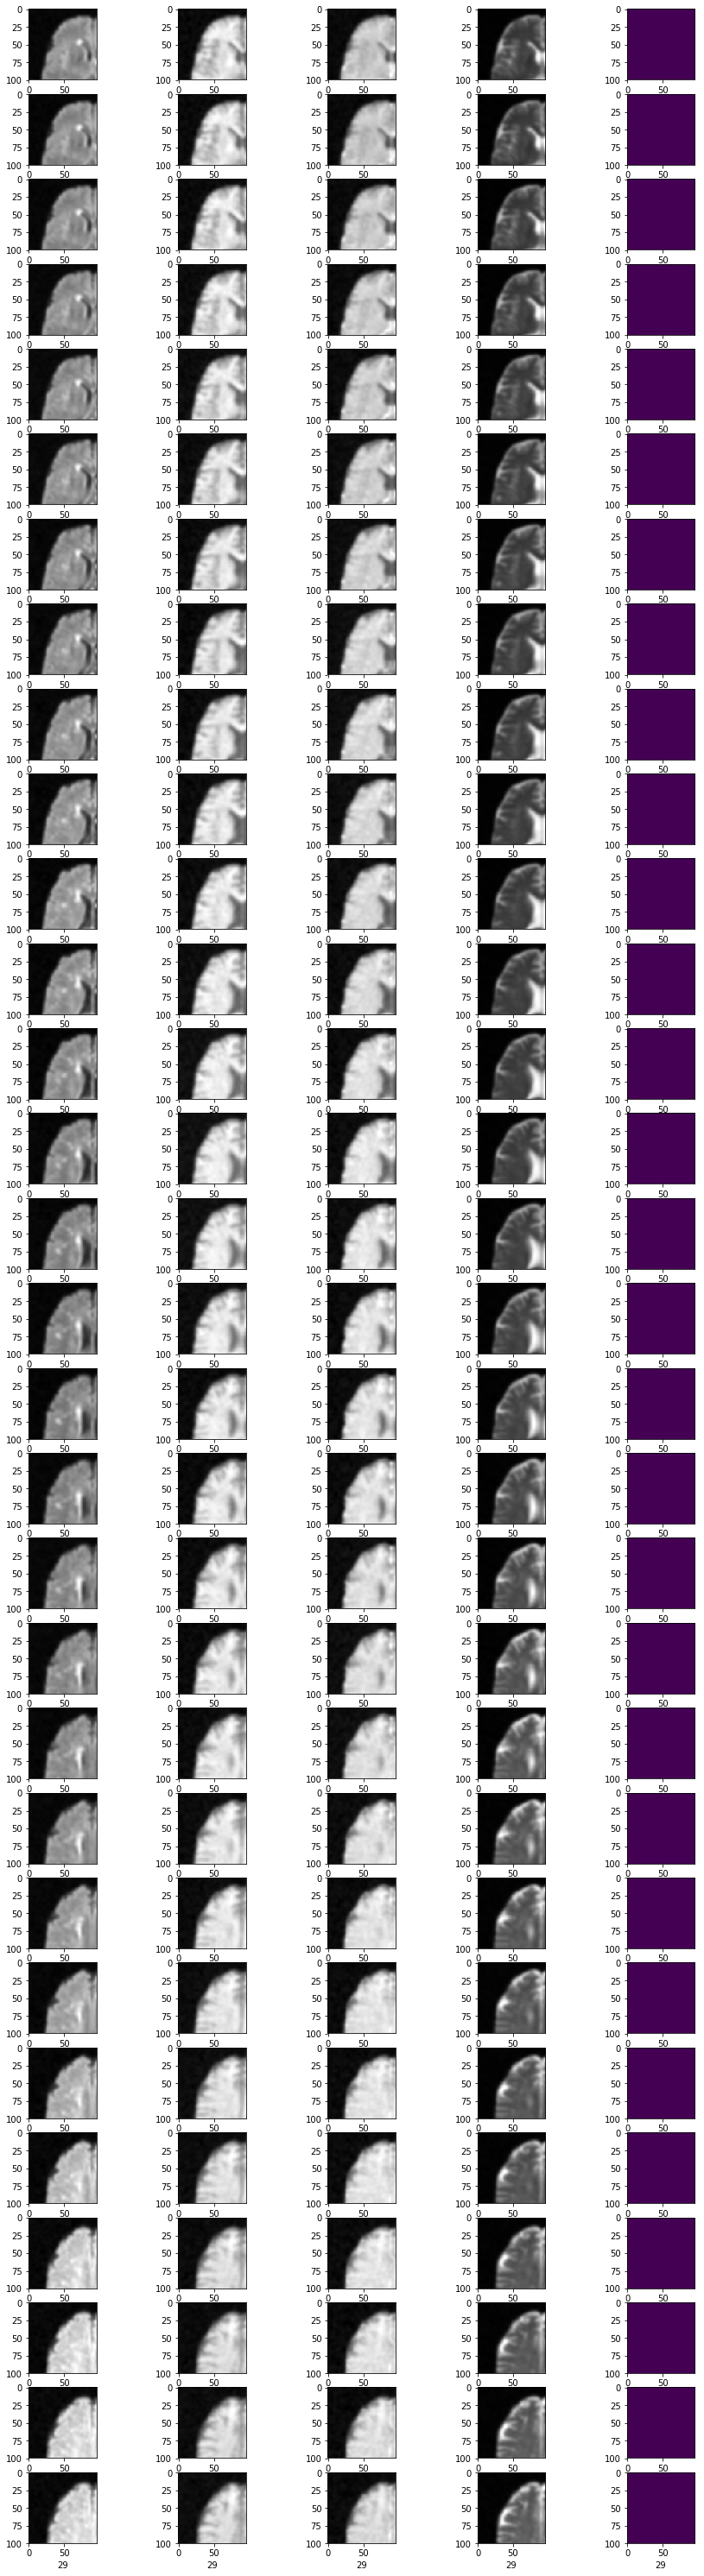

In [9]:

def single_patient(patient=None,rows=30,base=15):
    # to see across modalities of single patient
    # each col is a modality
    
    fig = plt.figure(figsize=(15,54))
    if patient==None:
        im=next(dsi)
        image = im['img']
        mask=im['seg_orig']
        
        for i in range(5):
            
            if i<4:im1=image[i]; im1=np.swapaxes(im1,1,2); im1=np.swapaxes(im1,0,1)
            else:im1=mask; im1=np.swapaxes(im1,1,2); im1=np.swapaxes(im1,0,1)
            
            for j in range(rows):
                
                plt.subplot(rows,5,i+5*j+1)
                
                single=im1[base+j]
                
                if i<4:plt.imshow(single,cmap='gray')
                else: plt.imshow(single)
                xlab=str(j)
                plt.xlabel(xlab)
        plt.show()

single_patient(base=60)